<a href="https://colab.research.google.com/github/seojeongbin/web1/blob/master/project_%EA%B8%B0%EC%98%A8%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 청주시 용암1동 기온 예측하기
* 학과 : 산업공학과
* 학번/성명 : 201727525/서정빈

## 1. 데이터 소개
* 출처 : 기상청 기상자료개발포털
* 매 시각 30분부터 1시간동안 10분마다 발표
* 피처소개
  * 강수형태 : 없음(0), 비(1), 비/눈(2), 진눈깨비(3)
  * 하늘상태 : 맑음(1), 구름많음(3), 흐림(4)
  * 그 외 피처 보고서 서술


## 2. 데이터 확인 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
data = pd.read_csv("data.csv", encoding='cp949')
data.shape

(43082, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43082 entries, 0 to 43081
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      43082 non-null  int64  
 1   시간      43082 non-null  int64  
 2   강수      43082 non-null  float64
 3   강수형태    43082 non-null  int64  
 4   기온      43082 non-null  float64
 5   습도      43082 non-null  int64  
 6   풍속      43082 non-null  float64
 7   풍향      43082 non-null  int64  
 8   하늘상태    43082 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 3.0 MB


In [ ]:
data.습도 = data.습도.astype(float)
data.풍향 = data.풍향.astype(float)
data.시간 = data.시간.astype(float)
data.강수형태 = data.강수형태.astype(float)
data.하늘상태 = data.하늘상태.astype(float)

In [ ]:
data.head(13)

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
0,1,30.0,0.0,0.0,-2.3,65.0,0.6,278.0,4.0
1,1,30.0,0.0,0.0,-0.6,65.0,0.9,275.0,4.0
2,1,30.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
3,1,30.0,0.0,0.0,1.7,60.0,1.3,277.0,4.0
4,1,30.0,0.0,0.0,-1.2,70.0,0.6,284.0,4.0
5,1,30.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
6,1,130.0,0.0,0.0,-1.2,70.0,0.6,284.0,4.0
7,1,130.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
8,1,130.0,0.0,0.0,1.7,60.0,1.3,277.0,4.0
9,1,130.0,0.0,0.0,2.3,60.0,1.3,280.0,4.0


In [ ]:
# '시간' 데이터 변경하기 : 매 시간 30분에 10분마다 관측한 값을 표기한 형태이므로, 30(분)을 제외하고 시만 표기한다
def function(row):
    return row//100

data["시간"] = data["시간"].apply(function)

data.head(13)

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
0,1,0.0,0.0,0.0,-2.3,65.0,0.6,278.0,4.0
1,1,0.0,0.0,0.0,-0.6,65.0,0.9,275.0,4.0
2,1,0.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
3,1,0.0,0.0,0.0,1.7,60.0,1.3,277.0,4.0
4,1,0.0,0.0,0.0,-1.2,70.0,0.6,284.0,4.0
5,1,0.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
6,1,1.0,0.0,0.0,-1.2,70.0,0.6,284.0,4.0
7,1,1.0,0.0,0.0,1.0,65.0,1.3,274.0,4.0
8,1,1.0,0.0,0.0,1.7,60.0,1.3,277.0,4.0
9,1,1.0,0.0,0.0,2.3,60.0,1.3,280.0,4.0


In [ ]:
# 풍속이 0인데 풍향이 값을 갖는경우, 풍향이 0인데 풍속이 값을 갖는경우는 데이터입력오류로 추정되므로 삭제해준다
case1 = data[(data['풍속']==0) & (data['풍향'] !=0)].index
data = data.drop(case1)
case2 = data[(data['풍향']==0) & (data['풍속'] !=0)].index
data = data.drop(case2)
data.shape

(34337, 9)

In [ ]:
data.기온.describe()

count    34337.000000
mean        11.586379
std          9.801620
min        -15.900000
25%          3.000000
50%         11.000000
75%         20.000000
max         34.000000
Name: 기온, dtype: float64

In [ ]:
data.isnull().sum()

날짜      0
시간      0
강수      0
강수형태    0
기온      0
습도      0
풍속      0
풍향      0
하늘상태    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

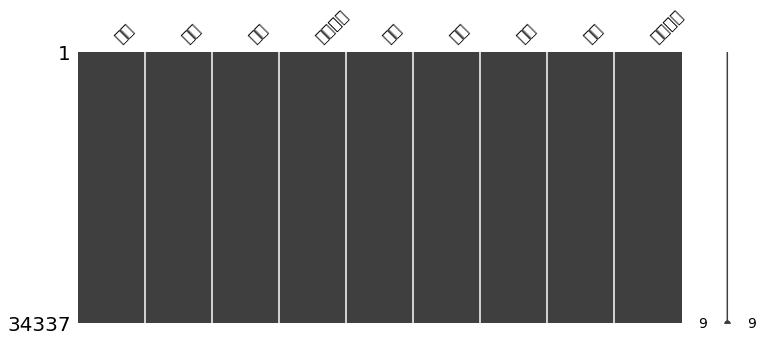

In [ ]:
import missingno as msno

msno.matrix(data, figsize=(12,5))

### 데이터프레임 정규화 

In [ ]:
cols = ["날짜","시간","강수","강수형태","기온","습도","풍속","풍향","하늘상태"]
data[cols] = (data[cols]-data[cols].min())/(data[cols].max()-data[cols].min())
data.head(13)

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
0,0.0,0.000000,0.0,0.222222,0.272545,0.656863,0.113043,0.773481,1.0
1,0.0,0.000000,0.0,0.222222,0.306613,0.656863,0.126087,0.765193,1.0
2,0.0,0.000000,0.0,0.222222,0.338677,0.656863,0.143478,0.762431,1.0
3,0.0,0.000000,0.0,0.222222,0.352705,0.607843,0.143478,0.770718,1.0
4,0.0,0.000000,0.0,0.222222,0.294589,0.705882,0.113043,0.790055,1.0
5,0.0,0.000000,0.0,0.222222,0.338677,0.656863,0.143478,0.762431,1.0
6,0.0,0.043478,0.0,0.222222,0.294589,0.705882,0.113043,0.790055,1.0
7,0.0,0.043478,0.0,0.222222,0.338677,0.656863,0.143478,0.762431,1.0
8,0.0,0.043478,0.0,0.222222,0.352705,0.607843,0.143478,0.770718,1.0
9,0.0,0.043478,0.0,0.222222,0.364729,0.607843,0.143478,0.779006,1.0


## 3. 탐색적 데이터 시각화 

[Text(0.5, 0, '풍속'), Text(0.5, 1.0, 'wind speed->Temperature')]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text

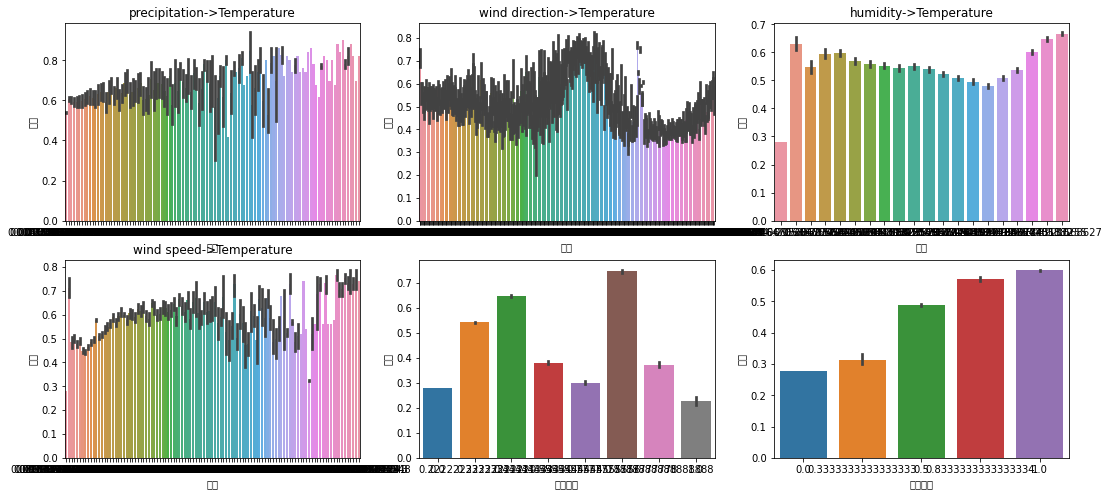

In [ ]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=data, x="강수", y="기온", ax=ax1)
sns.barplot(data=data, x="풍향", y="기온", ax=ax2)
sns.barplot(data=data, x="습도", y="기온", ax=ax3)
sns.barplot(data=data, x="풍속", y="기온", ax=ax4)
sns.barplot(data=data, x="강수형태", y="기온", ax=ax5)
sns.barplot(data=data, x="하늘상태", y="기온", ax=ax6)

ax1.set(ylabel='기온',title="precipitation->Temperature")
ax2.set(xlabel='풍향',title="wind direction->Temperature")
ax3.set(xlabel='습도', title="humidity->Temperature")
ax4.set(xlabel='풍속', title="wind speed->Temperature")

* 위에서 우측방향 차례로 (강수량, 풍향, 습도, 풍속, 강수형태, 하늘형태) 에 따른 기온
* 강수량과 기온에 대해서는, 강수량이 많아도 보통 날이 더운 여름에 비가 많이와서 그런지 강수량과 기온이 반비례하지는 않았다
* 풍향은 180도 값의 경우가 기온에 가장 크게 영향을 미쳤으며 선대칭적인 양상을 보였다
* 습도는 80%를 기점으로 비례관계가 변하였다 (반비례 -> 비례)
* 강수형태, 하늘상태에 피쳐해석은 보고서에 서술한다. 하지만 raw data 제공처 (기상청) 에서 -2인 값은 없었다. -2값은 데이터 최초 기입 시 작업자 실수로 보인다. (습도 -2 마찬가지)

In [ ]:
# 강수형태, 하늘상태, 습도 == -2 데이터 삭제

data.강수형태 = data.강수형태.astype(float)
data.하늘상태 = data.하늘상태.astype(float)

data = data[data.강수형태 != -2]
data = data[data.하늘상태 != -2]
data = data[data.습도 != -2]

[Text(0, 0.5, 'temperature'),
 Text(0.5, 0, 'wind speed'),
 Text(0.5, 1.0, 'w.s -> temp')]

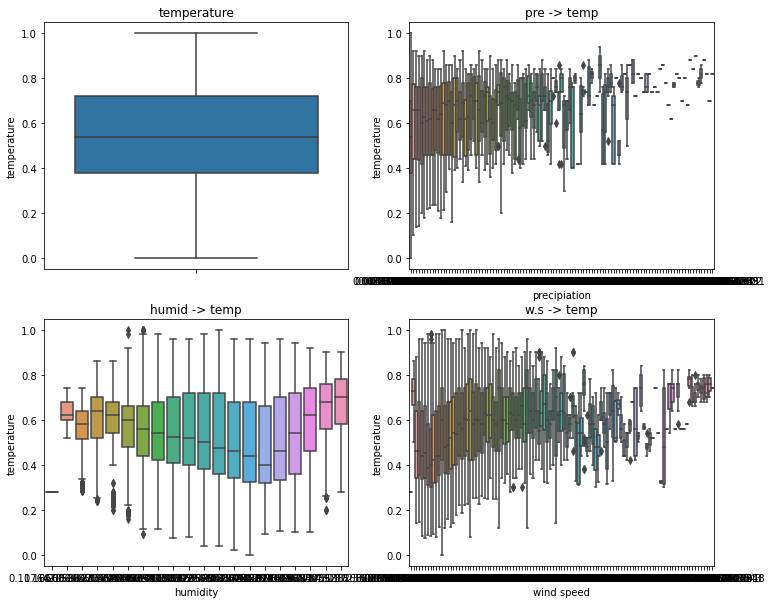

In [ ]:
# 변수가 기온에 미치는 수준 시각화

fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=data,y="기온",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="기온",x="강수",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="기온",x="습도",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="기온",x="풍속",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='temperature',title="temperature")
axes[0][1].set(xlabel='precipiation', ylabel='temperature',title="pre -> temp")
axes[1][0].set(xlabel='humidity', ylabel='temperature',title="humid -> temp")
axes[1][1].set(xlabel='wind speed', ylabel='temperature',title="w.s -> temp")

In [ ]:
corrMatt = data[["날짜", "시간", "강수", "강수형태", "기온", "습도", "풍속", "풍향", "하늘상태"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

            날짜        시간        강수  ...        풍속        풍향      하늘상태
날짜    1.000000 -0.004323 -0.014399  ...  0.058493 -0.049102  0.038474
시간   -0.004323  1.000000  0.000026  ... -0.174317 -0.059833  0.019175
강수   -0.014399  0.000026  1.000000  ...  0.028562 -0.018310  0.138932
강수형태 -0.000288 -0.001999  0.155299  ...  0.100189 -0.042968  0.238749
기온    0.063301 -0.270729  0.106837  ...  0.181933 -0.047314  0.266733
습도    0.046711  0.442795  0.169133  ... -0.150406 -0.163911  0.316203
풍속    0.058493 -0.174317  0.028562  ...  1.000000  0.035047  0.033568
풍향   -0.049102 -0.059833 -0.018310  ...  0.035047  1.000000 -0.058999
하늘상태  0.038474  0.019175  0.138932  ...  0.033568 -0.058999  1.000000

[9 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

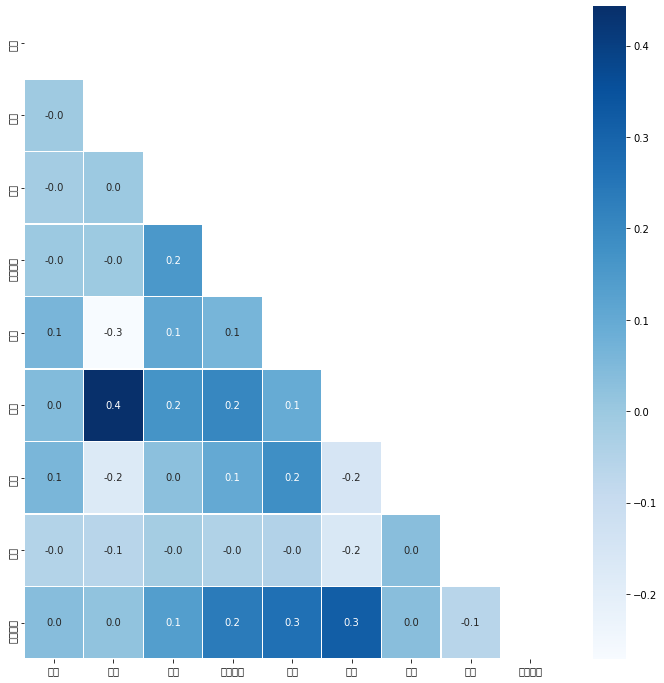

In [ ]:
f, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), annot=True, linewidths=0.4, linecolor='white', fmt='.1f', ax=ax, cmap='Blues', mask=mask)
plt.show()

* 서로간의 연관성이 약하다
* 습도와 시간이 비교적 연관성을 보이고 있다
**날짜의 경우 어느항목과도 연관성이 약한 양상을 갖기에 피쳐를 삭제해주기로 한다*

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text

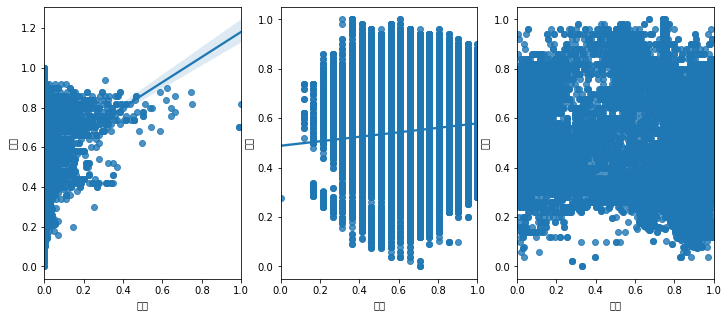

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="강수", y="기온", data=data,ax=ax1)
sns.regplot(x="습도", y="기온", data=data,ax=ax2)
sns.regplot(x="풍향", y="기온", data=data,ax=ax3)

### 이상치 탐색

In [ ]:
from collections import Counter
def detect_outliers(df,features):
  outlier_indices = 
  for c in features:
    Q1 = np.percentile(df[c],25)
    Q3 = np.percentile(df[c],75)
    IQR = Q3 - Q1
    outlier_step = IQR * 1.5
    outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index #filtre
    outlier_indices.extend(outlier_list_col)
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
  return multiple_outliers

In [ ]:
# 이상치 출력
data.loc[detect_outliers(data,["날짜","시간","강수","강수형태","기온","습도","풍속","풍향","하늘상태"])]

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
564,0.133333,0.695652,0.004505,0.555556,0.318637,0.607843,0.117391,0.290055,1.000000
568,0.133333,0.739130,0.004505,0.555556,0.318637,0.607843,0.117391,0.290055,1.000000
570,0.133333,0.782609,0.004505,0.555556,0.322645,0.607843,0.113043,0.198895,1.000000
571,0.133333,0.782609,0.009009,0.555556,0.320641,0.607843,0.108696,0.254144,1.000000
572,0.133333,0.782609,0.004505,0.555556,0.318637,0.607843,0.108696,0.314917,1.000000
...,...,...,...,...,...,...,...,...,...
42811,0.700000,0.782609,0.000000,1.000000,0.140281,0.656863,0.304348,0.881215,1.000000
42814,0.700000,0.826087,0.000000,1.000000,0.140281,0.705882,0.260870,0.906077,1.000000
42815,0.700000,0.826087,0.000000,1.000000,0.140281,0.656863,0.304348,0.892265,1.000000
42821,0.700000,0.913043,0.000000,1.000000,0.140281,0.656863,0.304348,0.900552,1.000000


In [ ]:
data = data.drop(detect_outliers(data,["날짜","시간","강수","강수형태","기온","습도","풍속","풍향","하늘상태"]))
data

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
0,0.000000,0.0,0.0,0.222222,0.272545,0.656863,0.113043,0.773481,1.0
1,0.000000,0.0,0.0,0.222222,0.306613,0.656863,0.126087,0.765193,1.0
2,0.000000,0.0,0.0,0.222222,0.338677,0.656863,0.143478,0.762431,1.0
3,0.000000,0.0,0.0,0.222222,0.352705,0.607843,0.143478,0.770718,1.0
4,0.000000,0.0,0.0,0.222222,0.294589,0.705882,0.113043,0.790055,1.0
...,...,...,...,...,...,...,...,...,...
43074,0.766667,1.0,0.0,0.222222,0.100200,0.852941,0.130435,0.502762,1.0
43075,0.766667,1.0,0.0,1.000000,0.160321,0.803922,0.130435,0.604972,1.0
43076,0.800000,0.0,0.0,1.000000,0.240481,0.705882,0.173913,0.674033,1.0
43080,0.800000,0.0,0.0,0.222222,0.220441,0.803922,0.130435,0.776243,1.0


### 최종 전처리 이후 상관관계 파악

In [ ]:
data.corr()

,날짜,시간,강수,강수형태,기온,습도,풍속,풍향,하늘상태
날짜,1.000000,-0.003447,0.008499,0.013990,0.073732,0.054479,0.013491,-0.049459,0.041037
시간,-0.003447,1.000000,0.006717,-0.001088,-0.277096,0.460801,-0.227213,-0.060347,0.020013
강수,0.008499,0.006717,1.000000,0.149471,0.083346,0.150064,-0.011475,0.026129,0.116470
강수형태,0.013990,-0.001088,0.149471,1.000000,0.046387,0.178825,0.019313,0.032110,0.206108
기온,0.073732,-0.277096,0.083346,0.046387,1.000000,0.070861,0.179842,-0.047729,0.265927
습도,0.054479,0.460801,0.150064,0.178825,0.070861,1.000000,-0.261588,-0.142180,0.298980
풍속,0.013491,-0.227213,-0.011475,0.019313,0.179842,-0.261588,1.000000,0.081313,-0.018260
풍향,-0.049459,-0.060347,0.026129,0.032110,-0.047729,-0.142180,0.081313,1.000000,-0.019733
하늘상태,0.041037,0.020013,0.116470,0.206108,0.265927,0.298980,-0.018260,-0.019733,1.000000


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

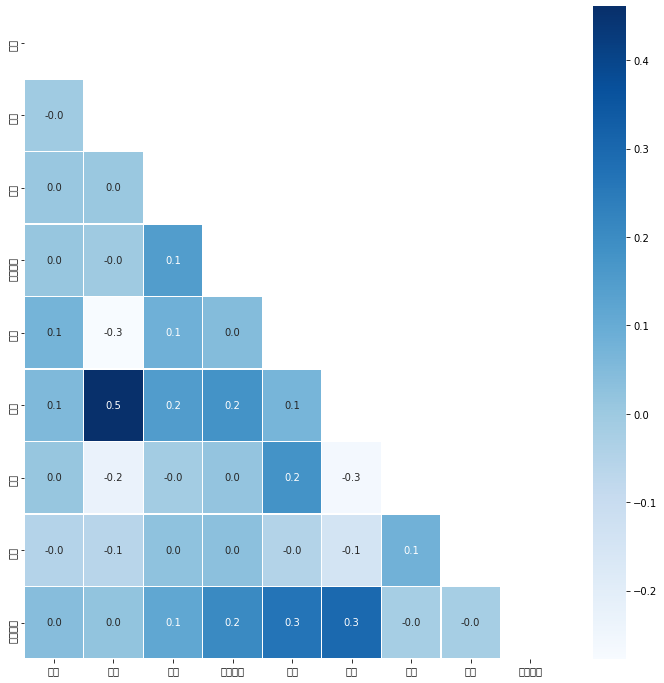

In [ ]:
f, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), annot=True, linewidths=0.4, linecolor='white', fmt='.1f', ax=ax, cmap='Blues', mask=mask)
plt.show()

## 4. 피처 선정 

In [ ]:
# 1. 범주형 데이터 분리
categorical_feature_names = ["날짜", "시간", "강수형태", "하늘상태"]

for var in categorical_feature_names:
    data[var] = data[var].astype("category")

In [ ]:
# 2. 피처 분리할당
feature_names = ["시간", "강수", "강수형태", "습도", "풍속", "풍향", "하늘상태"] # 기온과 날짜 제외

In [ ]:
data_x = data[feature_names]
print(data_x.shape)
data_x.head(10)

(32939, 7)


,시간,강수,강수형태,습도,풍속,풍향,하늘상태
0,0.000000,0.0,0.222222,0.656863,0.113043,0.773481,1.0
1,0.000000,0.0,0.222222,0.656863,0.126087,0.765193,1.0
2,0.000000,0.0,0.222222,0.656863,0.143478,0.762431,1.0
3,0.000000,0.0,0.222222,0.607843,0.143478,0.770718,1.0
4,0.000000,0.0,0.222222,0.705882,0.113043,0.790055,1.0
5,0.000000,0.0,0.222222,0.656863,0.143478,0.762431,1.0
6,0.043478,0.0,0.222222,0.705882,0.113043,0.790055,1.0
7,0.043478,0.0,0.222222,0.656863,0.143478,0.762431,1.0
8,0.043478,0.0,0.222222,0.607843,0.143478,0.770718,1.0
9,0.043478,0.0,0.222222,0.607843,0.143478,0.779006,1.0


In [ ]:
data_y = data['기온']
print(data_y.shape)
data_y.head()

(32939,)


0    0.272545
1    0.306613
2    0.338677
3    0.352705
4    0.294589
Name: 기온, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y) 

## 5. 알고리즘 선정 및 평가 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

### 선형회귀

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.20078373325933652


### 의사결정트리

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.9699841567327903


### 랜덤포레스트 

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.9330346024114099


### SVM 

In [ ]:
model = SVR(kernel='linear')
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.19583667209674127


In [ ]:
# 비선형 svm
model = SVR(kernel='poly')
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.3001280096718776


In [ ]:
# 비선형 svm
model = SVR(kernel='rbf')
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(score)

0.4400257036847802


### 최종결정모델 : 의사결정트리

## 예측과 평가

In [ ]:
model = DecisionTreeRegressor()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]


(8235,)


array([0.63927856, 0.57915832, 0.55911824, 0.37875752, 0.61923848,
       0.77955912, 0.55911824, 0.75951904, 0.45891784, 0.7995992 ])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predict = model.predict(X_test)

print(f"mean_absolute_error : {mean_absolute_error(y_test, predict)}")
print(f"mean_squared_error : {mean_squared_error(y_test, predict)}")
# RMSE
print(f"root_mean_squared_error : {np.sqrt(mean_squared_error(y_test, predict))}")

mean_absolute_error : 0.08694660433806
mean_squared_error : 0.02031761769978612
root_mean_squared_error : 0.1425398810852111
